In [1]:
!pip -q install auto-gptq
!pip -q install optimum
!pip -q install bitsandbytes
!pip -q uninstall torch -y
!pip -q install torch==2.1

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import ClapConfig, ClapModel, AutoProcessor
from transformers import ClapTextConfig, ClapAudioConfig
from peft import prepare_model_for_kbit_training
from peft import LoraConfig, get_peft_model
from datasets import load_dataset,DatasetDict
import transformers
import torch
import librosa
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import transformers
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c107WarningC1ENS_7variantIJNS0_11UserWarningENS0_18DeprecationWarningEEEERKNS_14SourceLocationENSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEEb'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-07-21 21:10:13.918261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 21:10:13.918367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT wh

In [39]:
config_text = ClapTextConfig()
config_audio = ClapAudioConfig()
model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to('cuda')
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")

In [40]:
model = prepare_model_for_kbit_training(model)

In [41]:
model.eval()

ClapModel(
  (text_model): ClapTextModel(
    (embeddings): ClapTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ClapTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x ClapTextLayer(
          (attention): ClapTextAttention(
            (self): ClapTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ClapTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [42]:
lora_target_modules = [
    "audio_model.audio_encoder.layers.*.blocks.*.attention.self.query",
    "audio_model.audio_encoder.layers.*.blocks.*.attention.self.key",
    "audio_model.audio_encoder.layers.*.blocks.*.attention.self.value",
    "audio_model.audio_encoder.layers.*.blocks.*.intermediate.dense",
    "audio_model.audio_encoder.layers.*.blocks.*.output.dense",
    "audio_projection.linear1",
    "audio_projection.linear2"
]

config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=lora_target_modules,
    lora_dropout=0.1,
    bias="none",
)

lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 36,864 || all params: 153,529,754 || trainable%: 0.0240


In [7]:
data = load_dataset("abh1shank/chord_classificarion_audio_data")

Generating train split:   0%|          | 0/859 [00:00<?, ? examples/s]

In [8]:
train_test_split = data['train'].train_test_split(test_size=0.1)

In [9]:
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'test': train_test_split['test']
})

In [10]:
def preprocess_function(data):
    audios = [librosa.load(audio_path, sr=48000)[0] for audio_path in data['audio']]
    text = [text for text in data['text']]
    
    inputs = processor(
        text=text,
        audios=audios,
        sampling_rate=48000,  
        padding=True,
        return_tensors='pt'
    )
    
    return inputs

In [20]:
processed_dataset_train=dataset_dict.map(preprocess_function,batched=True)

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

Map:   0%|          | 0/86 [00:00<?, ? examples/s]

In [43]:
lora_model.train()
lora_model.to('cuda')

PeftModel(
  (base_model): LoraModel(
    (model): ClapModel(
      (text_model): ClapTextModel(
        (embeddings): ClapTextEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): ClapTextEncoder(
          (layer): ModuleList(
            (0-11): 12 x ClapTextLayer(
              (attention): ClapTextAttention(
                (self): ClapTextSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
                (outp

In [44]:
def collate_fn(batch):
    input_ids = torch.stack([torch.tensor(item['input_ids']) for item in batch])
    attention_mask = torch.stack([torch.tensor(item['attention_mask']) for item in batch])
    input_features = torch.stack([torch.tensor(item['input_features']) for item in batch])
    
    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'input_features': input_features,
    }


train_dataloader = DataLoader(processed_dataset_train['train'], batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(processed_dataset_train['test'], batch_size=4, shuffle=False, collate_fn=collate_fn)

In [45]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lora_model.to(device)
loss_values_lora=[]
epoch_num=[]
optimizer = torch.optim.AdamW(lora_model.parameters(), lr=3e-2)
steps_per_epoch=194
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min', patience=steps_per_epoch*2, factor=0.3, verbose=True)

def contrastive_loss(logits_per_audio, logits_per_text, temperature=1.0):
    labels = torch.arange(logits_per_audio.size(0)).to(device)
    loss_audio = torch.nn.functional.cross_entropy(logits_per_audio / temperature, labels)
    loss_text = torch.nn.functional.cross_entropy(logits_per_text / temperature, labels)
    return (loss_audio + loss_text) / 2


for epoch in range(num_epochs):
    lora_model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        input_features = batch['input_features'].to(device)

        outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask, input_features=input_features)
        logits_per_audio = outputs.logits_per_audio
        logits_per_text = outputs.logits_per_text

        loss = contrastive_loss(logits_per_audio, logits_per_text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step(loss)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values_lora.append(avg_loss)
    epoch_num.append(epoch+1)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")


100%|██████████| 194/194 [00:57<00:00,  3.37it/s]


Epoch 1/20, Loss: 1.4547283342204143


100%|██████████| 194/194 [00:57<00:00,  3.35it/s]


Epoch 2/20, Loss: 1.38434924169914


100%|██████████| 194/194 [00:57<00:00,  3.37it/s]


Epoch 3/20, Loss: 1.3856983860743415


  1%|          | 1/194 [00:00<00:57,  3.35it/s]

Epoch 00583: reducing learning rate of group 0 to 9.0000e-03.


100%|██████████| 194/194 [00:58<00:00,  3.32it/s]


Epoch 4/20, Loss: 1.3719698442626245


100%|██████████| 194/194 [00:57<00:00,  3.36it/s]


Epoch 5/20, Loss: 1.3691494722956234


  1%|          | 2/194 [00:00<00:57,  3.37it/s]

Epoch 00972: reducing learning rate of group 0 to 2.7000e-03.


100%|██████████| 194/194 [00:58<00:00,  3.32it/s]


Epoch 6/20, Loss: 1.3666919672612063


100%|██████████| 194/194 [00:57<00:00,  3.38it/s]


Epoch 7/20, Loss: 1.3521373523879296


  2%|▏         | 3/194 [00:00<01:00,  3.15it/s]

Epoch 01361: reducing learning rate of group 0 to 8.1000e-04.


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 8/20, Loss: 1.3561635134146386


100%|██████████| 194/194 [00:57<00:00,  3.36it/s]


Epoch 9/20, Loss: 1.3536731821974528


  2%|▏         | 4/194 [00:01<00:55,  3.42it/s]

Epoch 01750: reducing learning rate of group 0 to 2.4300e-04.


100%|██████████| 194/194 [00:57<00:00,  3.38it/s]


Epoch 10/20, Loss: 1.350109118776223


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 11/20, Loss: 1.3410823246867387


  3%|▎         | 5/194 [00:01<00:56,  3.35it/s]

Epoch 02139: reducing learning rate of group 0 to 7.2900e-05.


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 12/20, Loss: 1.3503277676621663


100%|██████████| 194/194 [00:58<00:00,  3.31it/s]


Epoch 13/20, Loss: 1.35170604273216


  3%|▎         | 6/194 [00:01<00:56,  3.31it/s]

Epoch 02528: reducing learning rate of group 0 to 2.1870e-05.


100%|██████████| 194/194 [00:58<00:00,  3.30it/s]


Epoch 14/20, Loss: 1.3582392070711273


100%|██████████| 194/194 [00:59<00:00,  3.29it/s]


Epoch 15/20, Loss: 1.3465930198885732


  4%|▎         | 7/194 [00:02<01:00,  3.11it/s]

Epoch 02917: reducing learning rate of group 0 to 6.5610e-06.


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 16/20, Loss: 1.340705443288862


100%|██████████| 194/194 [00:58<00:00,  3.31it/s]


Epoch 17/20, Loss: 1.347059321157711


  4%|▍         | 8/194 [00:02<00:55,  3.37it/s]

Epoch 03306: reducing learning rate of group 0 to 1.9683e-06.


100%|██████████| 194/194 [00:58<00:00,  3.33it/s]


Epoch 18/20, Loss: 1.3386035610720055


100%|██████████| 194/194 [00:57<00:00,  3.36it/s]


Epoch 19/20, Loss: 1.3492543998452806


  5%|▍         | 9/194 [00:02<00:55,  3.32it/s]

Epoch 03695: reducing learning rate of group 0 to 5.9049e-07.


100%|██████████| 194/194 [00:57<00:00,  3.37it/s]

Epoch 20/20, Loss: 1.3456842708833439


In [46]:
model.to(device)
optimizer1 = torch.optim.AdamW(model.parameters(), lr=3e-2)
steps_per_epoch=194
scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer1,mode='min', patience=steps_per_epoch*2, factor=0.3, verbose=True)

loss_values_main=[]
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        input_features = batch['input_features'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, input_features=input_features)
        logits_per_audio = outputs.logits_per_audio
        logits_per_text = outputs.logits_per_text

        loss = contrastive_loss(logits_per_audio, logits_per_text)
        optimizer1.zero_grad()
        loss.backward()
        optimizer1.step()
        scheduler1.step(loss)

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_values_main.append(avg_loss)
    epoch_num.append(epoch+1)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")

100%|██████████| 194/194 [00:57<00:00,  3.38it/s]


Epoch 1/20, Loss: 1.3761170617083913


100%|██████████| 194/194 [00:57<00:00,  3.37it/s]


Epoch 2/20, Loss: 1.371671462796398


100%|██████████| 194/194 [00:57<00:00,  3.38it/s]


Epoch 3/20, Loss: 1.3668083947958405


  1%|          | 1/194 [00:00<00:57,  3.38it/s]

Epoch 00583: reducing learning rate of group 0 to 9.0000e-03.


100%|██████████| 194/194 [00:58<00:00,  3.33it/s]


Epoch 4/20, Loss: 1.3412420903284525


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 5/20, Loss: 1.3414022455510406


  1%|          | 2/194 [00:00<00:56,  3.37it/s]

Epoch 00972: reducing learning rate of group 0 to 2.7000e-03.


100%|██████████| 194/194 [00:57<00:00,  3.36it/s]


Epoch 6/20, Loss: 1.3327362180985127


100%|██████████| 194/194 [00:58<00:00,  3.34it/s]


Epoch 7/20, Loss: 1.3255329715836908


  2%|▏         | 3/194 [00:00<00:58,  3.27it/s]

Epoch 01361: reducing learning rate of group 0 to 8.1000e-04.


100%|██████████| 194/194 [00:58<00:00,  3.33it/s]


Epoch 8/20, Loss: 1.3101289355263268


100%|██████████| 194/194 [00:58<00:00,  3.29it/s]


Epoch 9/20, Loss: 1.3168249821540006


  2%|▏         | 4/194 [00:01<01:00,  3.12it/s]

Epoch 01750: reducing learning rate of group 0 to 2.4300e-04.


100%|██████████| 194/194 [00:58<00:00,  3.30it/s]


Epoch 10/20, Loss: 1.3327518947345693


100%|██████████| 194/194 [00:59<00:00,  3.27it/s]


Epoch 11/20, Loss: 1.3011235247567756


  3%|▎         | 5/194 [00:01<00:56,  3.33it/s]

Epoch 02139: reducing learning rate of group 0 to 7.2900e-05.


100%|██████████| 194/194 [00:58<00:00,  3.31it/s]


Epoch 12/20, Loss: 1.3273919492038255


100%|██████████| 194/194 [00:59<00:00,  3.28it/s]


Epoch 13/20, Loss: 1.3088233553871667


  3%|▎         | 6/194 [00:01<00:56,  3.35it/s]

Epoch 02528: reducing learning rate of group 0 to 2.1870e-05.


100%|██████████| 194/194 [00:58<00:00,  3.31it/s]


Epoch 14/20, Loss: 1.3091474077136247


100%|██████████| 194/194 [00:58<00:00,  3.32it/s]


Epoch 15/20, Loss: 1.322816760884118


  4%|▎         | 7/194 [00:02<00:57,  3.28it/s]

Epoch 02917: reducing learning rate of group 0 to 6.5610e-06.


100%|██████████| 194/194 [00:58<00:00,  3.29it/s]


Epoch 16/20, Loss: 1.334000627711876


100%|██████████| 194/194 [00:58<00:00,  3.31it/s]


Epoch 17/20, Loss: 1.308201802452815


  4%|▍         | 8/194 [00:02<00:55,  3.33it/s]

Epoch 03306: reducing learning rate of group 0 to 1.9683e-06.


100%|██████████| 194/194 [00:58<00:00,  3.30it/s]


Epoch 18/20, Loss: 1.320146691246131


100%|██████████| 194/194 [00:58<00:00,  3.32it/s]


Epoch 19/20, Loss: 1.2988545771726627


  5%|▍         | 9/194 [00:02<00:56,  3.30it/s]

Epoch 03695: reducing learning rate of group 0 to 5.9049e-07.


100%|██████████| 194/194 [00:59<00:00,  3.28it/s]

Epoch 20/20, Loss: 1.3230683112267367


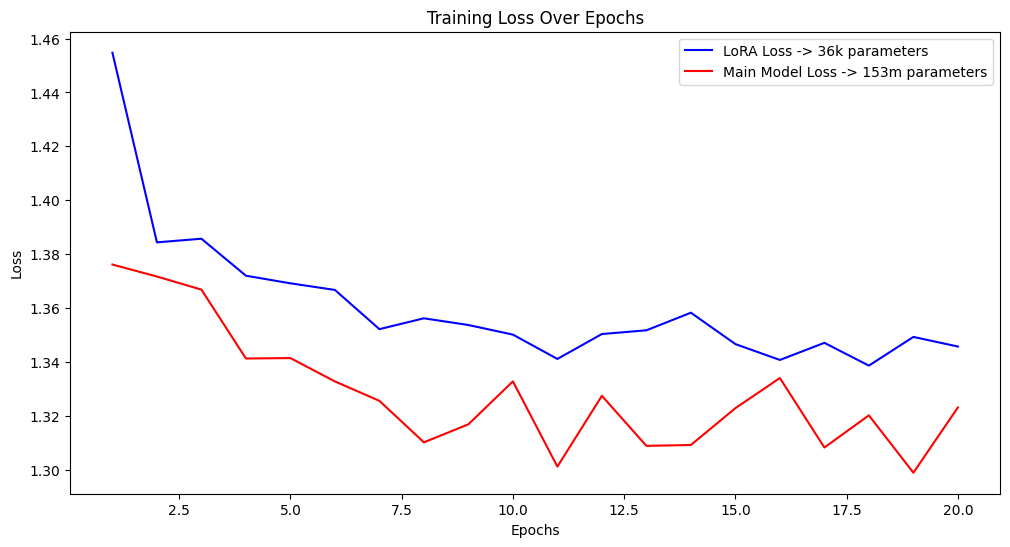

In [50]:
epochs=[i+1 for i in range(20)]
plt.figure(figsize=(12, 6))
plt.plot(epochs, loss_values_lora, color='b', label='LoRA Loss -> 36k parameters')
plt.plot(epochs, loss_values_main, color='r', label='Main Model Loss -> 153m parameters')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()